### **Capstone Project: SkimLit**

In [1]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

import sys
sys.path.append('/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/')

import important_functionalities as impf

2025-04-12 15:06:15.779017: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
baseline_results = {'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

model_1_results = {'accuracy': 78.85939361842976,
 'precision': 0.7857351875581878,
 'recall': 0.7885939361842976,
 'f1_score': 0.7863604692957813}

In [3]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

# check all of the filenames in the target directory
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]

In [4]:
def get_lines(filename):
    '''
    Reads file given a filename (text) and returns the lines of text as a list.
    '''
    with open(filename,'r') as file:
        return file.readlines()

In [5]:
def preprocess_text_with_line_number(filename):
    '''
    Takes in filename (str), reads its content and sorts through each line.
    Extracts things like the target label, the text of the sentence, how many sentences are in the current abstract and what sentence number the target line is.
    Returns a list of dictationaries of abstract line data.
    '''

    input_lines = get_lines(filename) # get all lines from file name
    abstract_lines = '' # create an empty abstract 
    abstract_samples = [] # create an empty list of abstracts

    # loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'): # check to see if line is an ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract string for every new abstract
            
        elif line.isspace(): # check to see if line is a newline
            abstract_lines_split = abstract_lines.splitlines() # split abstract into separate lines ('\n')

            # this is one particular abstract we are dealing with
            # iterate through each line in a single abstract, and count them at the same time.
            for abstract_line_no,abstract_line in enumerate(abstract_lines_split):
                line_data = {} # create an empty dictationary for each line
                target_text_split = abstract_line.split("\t")
                # text before \t is label, and after \t is text

                line_data['target'] = target_text_split[0] # get target label
                line_data['text'] = target_text_split[1].lower() # get target text and lowercase it
                line_data['line_number'] = abstract_line_no # what number line does the line appear in the abstract?
                line_data["total_lines"] = len(abstract_lines_split) - 1 # how many total lines are there in the target abstract ? (start from 0)
                
                # add line data to abstract samples list
                abstract_samples.append(line_data)

        else: # if the above conditions are not fulfilled, the line contains a labelled sentence
            abstract_lines += line
    
    return abstract_samples

In [6]:
%%time
# get data from file and pre-process it

train_samples = preprocess_text_with_line_number(data_dir+'train.txt')
val_samples = preprocess_text_with_line_number(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_number(data_dir+'test.txt')
len(train_samples),len(val_samples),len(test_samples)

CPU times: user 346 ms, sys: 146 ms, total: 491 ms
Wall time: 490 ms


(180040, 30212, 30135)

In [7]:
# # turning data into dataframe to further visualize
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [8]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [9]:
# NUMERIC_LABELLING
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [10]:
# ONE_HOT_ENCODING
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False) # we want non-sparse matrix

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [11]:
# Get the class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
print(class_names,num_classes)

['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS'] 5


In [12]:
# how long is each sentence on an average?
sen_len = [len(sen.split()) for sen in train_sentences]
avg_sentence_len = tf.reduce_mean(sen_len)
print(avg_sentence_len)

tf.Tensor(26, shape=(), dtype=int32)


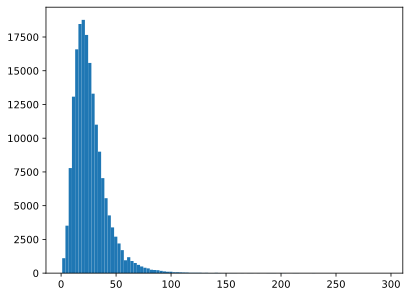

In [13]:
# what's the distribution look like?
plt.hist(sen_len,bins = 100);


In [14]:
# how long of a sentence length covers 95% of all sentences
output_seq_len = int(np.percentile(sen_len,95))
print(output_seq_len)

55


In [15]:
# what's the max length of sentence
tf.reduce_max(sen_len)

<tf.Tensor: shape=(), dtype=int32, numpy=296>

In [16]:
# Vocabulary size (refer paper: for PUBMED-20k it is 68k)
MAX_TOKENS  = 68000

In [17]:
# creating the text-vectorizer layer
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = MAX_TOKENS, # no of words in vocab
                                                    output_sequence_length = output_seq_len, # desired output length of vectorized sequences
                                                    # all other params kept default,
                                                    name = 'text_vectorizer'
                                                    )

In [18]:
# adapt the text vectorizer to train sentences
text_vectorizer.adapt(train_sentences)

**6.Using pretrained embedding layer**

* Paper uses GloVe (Global Vectors for Word Representation) embeddings.
  REFERENCE: https://nlp.stanford.edu/projects/glove/
* We will be using more modern version of word-embeddings (Universal Sentence Encoder)

In [21]:
import tensorflow_hub as hub
@kr.saving.register_keras_serializable(package="my_custom_package")
class UniversalEncodedLayer(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.use_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                        input_shape = [],
                                        dtype=tf.string,
                                        trainable=False, # default=False,
                                        name='USE'
                                        )

    def call(self,inputs):
        return self.use_layer(inputs)


In [31]:
# show an example embedding
import random
embedding_layer = UniversalEncodedLayer()

target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nEmbedded text: {embedding_layer(inputs=[target_sentence])} ')
print(f'Shape of embedded text:{embedding_layer(inputs=[target_sentence]).shape}')

Text:
the aim of this prospective single-blinded study was to analyze the stone-free ( sf ) rates between pneumatic lithotripsy ( pl ) and laser lithotripsy ( ll ) for the treatment of single and primary ureteral stones and to evaluate potentially predictive factors of a sf status .

Embedded text: [[ 1.99404312e-03 -7.62119442e-02 -6.11236356e-02 -1.19907968e-02
   4.84473221e-02 -7.80242234e-02 -7.01148733e-02  2.05900360e-04
   1.91523544e-02 -1.54463043e-02  4.08852808e-02 -4.41343151e-02
  -4.13593017e-02  5.95455524e-04  3.74105312e-02 -2.58935001e-02
  -1.33689223e-02  2.28511193e-03  1.05492119e-02  1.73478555e-02
   2.95218546e-02 -2.34679040e-02 -5.11966348e-02  2.79333573e-02
   7.80476332e-02  7.43106827e-02  7.64357951e-03  2.06176639e-02
   2.40873229e-02 -3.72093022e-02  8.48947279e-03  4.07223627e-02
   3.59373391e-02  5.18412553e-02 -6.79013059e-02  1.55142592e-02
  -2.21553817e-02  2.43428722e-02  1.31728202e-02  2.49045473e-02
  -6.17482699e-03  1.70832835e-02 -3.496

In [32]:
# creating datasets using tf.data API

### Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

### Take the Tensor slice datasets and turn them into prefetched datasets
BATCH_SIZE = 32
train_dataset = train_dataset.batch(batch_size = BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size = BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size = BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

**7. Pretrained token embedding: USE-embedding layer + Dense layer**

In [40]:
inputs = tf.keras.layers.Input(shape = [],dtype=tf.string)
token_embeddings = UniversalEncodedLayer()(inputs = inputs) # create embedding
x = tf.keras.layers.Dense(units = 128, activation='relu')(token_embeddings)
outputs = tf.keras.layers.Dense(units = num_classes,activation = 'softmax')(x)

# create the model
model_2 = tf.keras.models.Model(inputs = inputs, outputs=outputs)
model_2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ universal_encoded_layer_13      │ (None, 512)            │             0 │
│ (UniversalEncodedLayer)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# compile the model
model_2.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

In [42]:
# fitting the model
model_2.fit(train_dataset,
            steps_per_epoch = int(0.1*len(train_dataset)),
            epochs = 3,
            validation_data = valid_dataset,
            validation_steps = int(0.1*len(valid_dataset))
            )

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5784 - loss: 1.1005 - val_accuracy: 0.6902 - val_loss: 0.7950
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7042 - loss: 0.7690 - val_accuracy: 0.7051 - val_loss: 0.7538
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7169 - loss: 0.7530 - val_accuracy: 0.7131 - val_loss: 0.7381


In [43]:
# evaluate model 1
model_2.evaluate(valid_dataset)

  1/945 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.4062 - loss: 1.1124

945/945 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7139 - loss: 0.7385


[0.7398771047592163, 0.7143188118934631]

In [44]:
# make predictions using model 1
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs,model_2_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


(array([[4.0248978e-01, 4.1035777e-01, 2.3246221e-03, 1.7738040e-01,
         7.4473047e-03],
        [3.1368113e-01, 5.6845707e-01, 4.0755328e-03, 1.1134087e-01,
         2.4454524e-03],
        [2.4411152e-01, 1.5802659e-01, 1.8390302e-02, 5.4437715e-01,
         3.5094522e-02],
        ...,
        [1.5636083e-03, 6.8236943e-03, 5.3472187e-02, 8.6402008e-04,
         9.3727654e-01],
        [4.9310778e-03, 5.0328065e-02, 2.4856947e-01, 1.6795837e-03,
         6.9449180e-01],
        [1.6866900e-01, 2.9017419e-01, 5.0050163e-01, 6.6816267e-03,
         3.3973496e-02]], dtype=float32),
 (30212, 5))

In [45]:
# convert pred-probs to classes

pred_labels = tf.argmax(model_2_pred_probs,axis=1)
pred_classes  = [class_names[label] for label in pred_labels]
pred_labels,pred_classes

(<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 2])>,
 ['CONCLUSIONS',
  'CONCLUSIONS',
  'OBJECTIVE',
  'METHODS',
  'RESULTS',
  'METHODS',
  'METHODS',
  'METHODS',
  'RESULTS',
  'CONCLUSIONS',
  'OBJECTIVE',
  'CONCLUSIONS',
  'OBJECTIVE',
  'OBJECTIVE',
  'METHODS',
  'METHODS',
  'OBJECTIVE',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'OBJECTIVE',
  'BACKGROUND',
  'BACKGROUND',
  'CONCLUSIONS',
  'METHODS',
  'CONCLUSIONS',
  'METHODS',
  'METHODS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'RESULTS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'RESULTS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'OBJECTIVE',
  'METHODS',
  'METHODS',
  'RESULTS',
  'METHODS',
  'METHODS',
  'RESULTS',
  'RESULTS',
  'METHODS',
  'RESULTS',
  'CONCLUSIONS',
  'METHODS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'CONCLUSIONS',
  'OBJECTIVE',
  'RESULTS',
  '

In [46]:
model_2_results = impf.calculate_results(val_labels_encoded,pred_labels)
model_2_results

{'accuracy': 71.4318813716404,
 'precision': 0.714442353759606,
 'recall': 0.714318813716404,
 'f1_score': 0.7113182138257264}

***-- CONTD IN NEXT NOTEBOOK --***